In [15]:
import scipy as sp
import openpnm as op
ws = op.Workspace()
ws.settings['loglevel'] = 40
pn = op.network.Cubic(shape=[10, 10, 10], spacing=0.0001, name='net')

In [1]:
from skimage.morphology import disk, ball

In [16]:
pn.keys()

dict_keys(['pore.all', 'throat.all', 'pore.coords', 'throat.conns', 'pore.internal', 'throat.internal', 'pore.surface', 'pore.front', 'pore.back', 'pore.left', 'pore.right', 'pore.top', 'pore.bottom', 'throat.surface'])

## Adding Boundary Pores

When performing transport simulations it is often useful to have 'boundary' pores attached to the surface(s) of the network where boundary conditions can be applied.  When using the **Cubic** class, two methods are available for doing this: ``add_boundaries``, which is specific for the **Cubic** class, and ``add_boundary_pores``, which is a generic method that can also be used on other network types and which is inherited from **GenericNetwork**.  The first method automatically adds boundaries to ALL six faces of the network and offsets them from the network by 1/2 of the value provided as the network ``spacing``.  The second method provides total control over which boundary pores are created and where they are positioned, but requires the user to specify to which pores the boundary pores should be attached to.  Let's explore these two options:

In [2]:
pn.add_boundary_pores(labels=['left', 'right'])

In [5]:
# fig = op.topotools.plot_connections(pn, c='r')
# fig = op.topotools.plot_coordinates(pn, c='b', fig=fig)
# fig.set_size_inches([10, 10])

In [6]:
Ps = pn.pores('*boundary', mode='not')
Ts = pn.throats('*boundary', mode='not')
geom = op.geometry.StickAndBall(network=pn, pores=Ps, throats=Ts, name='intern')

In [7]:
Ps = pn.pores('*boundary')
Ts = pn.throats('*boundary')
boun = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts, name='boun')

The **StickAndBall** class is preloaded with the pore-scale models to calculate all the necessary size information (pore diameter, pore.volume, throat lengths, throat.diameter, etc).  The **GenericGeometry** class used for the boundary pores is empty and requires work. Throat properties like length and diameter are used in OpenPNM's algorithms (e.g., drainage) a small value (0.001 nm) should be set to all of them. 

In [3]:
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

water = op.phases.Water(network=pn)
water.add_model(propname='throat.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn)

In [6]:
Ps = pn.pores(labels=['left'])

In [4]:
ip = op.algorithms.InvasionPercolation(network=pn)

In [8]:
ip.setup(phase=water)
ip.set_inlets(pores=Ps)
ip.run()

In [13]:
import openpnm as op
ws = op.Workspace()
proj = ws.new_project()
pn = op.network.Cubic(shape=[10, 10, 10], project=proj, spacing=1e-4)
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
geom['pore.volume'][pn.pores('left')] = 0
hg = op.phases.Mercury(network=pn)
phys = op.physics.GenericPhysics(network=pn, phase=hg, geometry=geom)
phys.add_model(propname='throat.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn)
phys.add_model(propname='pore.pc_star',
               model=op.models.misc.from_neighbor_throats,
               throat_prop='throat.entry_pressure',
               mode='min')
phys.add_model(propname='pore.late_filling',
               model=op.models.physics.multiphase.late_filling,
               pressure='pore.pressure',
               Pc_star='pore.pc_star',
               eta=1, Swp_star=0.4,
               regen_mode='deferred')
phys['throat.pc_star'] = phys['throat.entry_pressure']
phys.add_model(propname='throat.late_filling',
               model=op.models.physics.multiphase.late_filling,
               pressure='throat.pressure',
               Pc_star='throat.pc_star',
               eta=1, Swp_star=0.2,
               regen_mode='deferred')
mip = op.algorithms.Porosimetry(project=proj)
mip.setup(phase=hg)
mip.set_partial_filling(propname='pore.late_filling')
mip.set_inlets(pores=pn.pores('bottom'))
mip.run(points=20, stop=1e7)

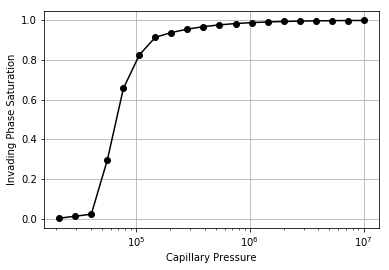

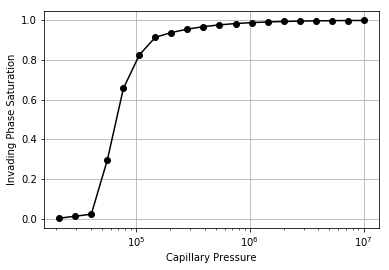

In [14]:
mip.plot_intrusion_curve()

In [12]:
ip.results()

{'pore.invasion_sequence': array([   0,    0,    0, ..., 2488, 1202, 2784]),
 'throat.invasion_sequence': array([2536, 2539, 1839, ..., 2488, 1202, 2784])}

In [4]:
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

In [ ]:
inv = op.algorithms.Drainage(network=pn)
inv.setup(invading_phase=water, defending_phase=air)
inv.set_inlets(pores=pn.pores(['top', 'bottom']))
inv.run()

In [20]:
import openpnm as op
import scipy as sp
import matplotlib.pyplot as plt


S = sp.array([100, 100, 1])
pn = op.network.Cubic(shape=S, spacing=0.0001, name='pn11')

geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

water = op.phases.Water(network=pn)
water.add_model(propname='throat.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn)

In [22]:
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=water)
ip.set_inlets(pores=0)
ip.run()

In [25]:
water.update(ip.results(Snwp=0.5))

In [32]:
ip.results(Snwp=0.5)

{'pore.occupancy': array([ True,  True,  True, ...,  True, False, False]),
 'throat.occupancy': array([ True,  True,  True, ...,  True, False, False])}

In [ ]:
ip.

In [31]:
water.keys()

dict_keys(['pore.all', 'throat.all', 'pore.temperature', 'pore.pressure', 'pore.molecular_weight', 'pore.critical_pressure', 'pore.critical_temperature', 'pore.critical_volume', 'pore.contact_angle', 'pore.electrical_conductivity', 'pore.diffusivity', 'pore.density', 'pore.molar_density', 'pore.surface_tension', 'pore.thermal_conductivity', 'pore.vapor_pressure', 'pore.viscosity', 'throat.entry_pressure', 'pore.occupancy', 'throat.occupancy'])

In [30]:
water['pore.critical_pressure']

array([22064000., 22064000., 22064000., ..., 22064000., 22064000.,
       22064000.])

In [19]:
algo = op.algorithms.GenericTransport()

In [ ]:
algo.setup()

In [18]:
dir(op.algorithms)

['AdvectionDiffusion',
 'ChargeConservationNernstPlanck',
 'Dispersion',
 'FickianDiffusion',
 'FourierConduction',
 'GenericAlgorithm',
 'GenericTransport',
 'InvasionPercolation',
 'MixedInvasionPercolation',
 'NernstPlanck',
 'NonNewtonianStokesFlow',
 'OhmicConduction',
 'OrdinaryPercolation',
 'Porosimetry',
 'ReactiveTransport',
 'StokesFlow',
 'TransientAdvectionDiffusion',
 'TransientFickianDiffusion',
 'TransientReactiveTransport',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [5]:
Hg = op.phases.Mercury(network=pn)
phys = op.physics.Standard(network=pn, phase=Hg, geometry=geom)
mip = op.algorithms.(network=pn)
mip.setup(phase=Hg)
mip.set_inlets(pores=pn.pores(['left', 'right']))
mip.run()

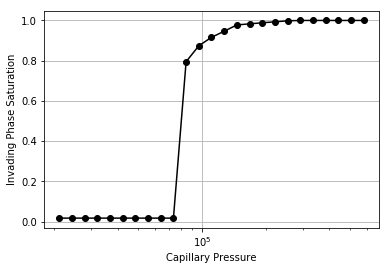

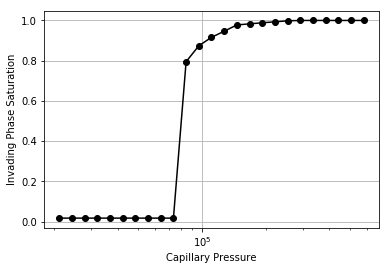

In [6]:
mip.plot_intrusion_curve()

In [8]:
Hg = op.phases.Mercury(network=pn)
phys = op.physics.Standard(network=pn, phase=Hg, geometry=geom)
mip = op.algorithms.Porosimetry(network=pn)

In [10]:
pn.labels()

['pore.all', 'pore.back', 'pore.bottom', 'pore.bottom_boundary', 'pore.boun', 'pore.front', 'pore.geo_03', 'pore.intern', 'pore.internal', 'pore.left', 'pore.left_boundary', 'pore.right', 'pore.right_boundary', 'pore.surface', 'pore.top', 'pore.top_boundary', 'throat.all', 'throat.bottom_boundary', 'throat.boun', 'throat.geo_03', 'throat.intern', 'throat.internal', 'throat.left_boundary', 'throat.right_boundary', 'throat.surface', 'throat.top_boundary']

In [ ]:
mip.set_outlets(pores=['left', 'right', 'top', 'bottom'])
mip.set_inlets(pores=[''])

In [15]:
mip.setup(phase=Hg)
# mip.set_inlets(pores=pn.pores(['left', 'right', 'top', 'bottom']), overwrite=True)
# mip.set_inlets(pores=Ps, overwrite=True)
mip.run()

/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/models/physics/hydraulic_conductance.py:526: RuntimeWarning: divide by zero encountered in true_divide
  return (1/gt/SFt + 1/g1/SF1 + 1/g2/SF2)**(-1)
/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/models/physics/diffusive_conductance.py:278: RuntimeWarning: divide by zero encountered in true_divide
  return (1/gt/SFt + 1/g1/SF1 + 1/g2/SF2)**(-1)
/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/models/physics/thermal_conductance.py:178: RuntimeWarning: divide by zero encountered in true_divide
  return (1/gt/SFt + 1/g1/SF1 + 1/g2/SF2)**(-1)
/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/models/physics/electrical_conductance.py:178: RuntimeWarning: divide by zero encountered in true_divide
  return (1/gt/SFt + 1/g1/SF1

In [6]:
boun['pore.diameter'] = 0
boun['pore.volume'] = 0
boun['throat.diameter'] = 1e-12
boun['throat.length'] = 1e-12
boun['throat.volume'] = sp.pi*boun['throat.diameter']**2/4*boun['throat.length']

## Define Multiple Phase Objects

In order to simulate relative permeability of air through a partially water-filled network, we need to create each **Phase** object.  OpenPNM includes pre-defined classes for each of these common fluids:

/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/algorithms/OrdinaryPercolation.py:518: RuntimeWarning: invalid value encountered in less_equal
  Psatn = self['pore.invasion_pressure'] <= Pc
/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/openpnm-2.1.0b1-py3.7.egg/openpnm/algorithms/OrdinaryPercolation.py:519: RuntimeWarning: invalid value encountered in less_equal
  Tsatn = self['throat.invasion_pressure'] <= Pc


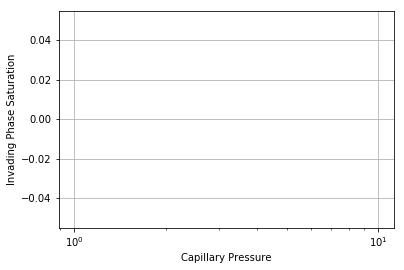

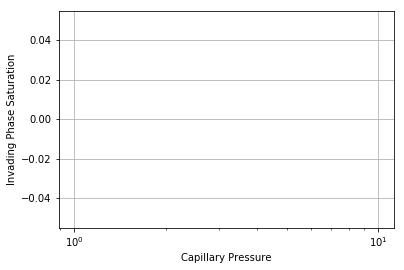

In [16]:
mip.plot_intrusion_curve()

In [12]:
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
water['throat.contact_angle'] = 110
water['throat.surface_tension'] = 0.072

In [13]:
phys = op.physics.Standard(network=pn, phase=water, geometry=geom)
mip = op.algorithms.Porosimetry(network=pn)
mip.setup(phase=water)
mip.set_inlets(pores=pn.pores(['left', 'right', 'top', 'bottom']))
mip.run()

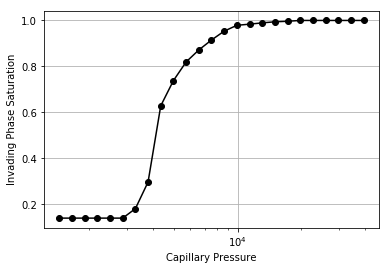

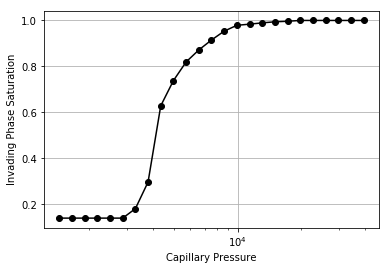

In [14]:
mip.plot_intrusion_curve()

### Aside: Creating a Custom Phase Class

In many cases you will want to create your own fluid, such as an oil or brine, which may be commonly used in your research.  OpenPNM cannot predict all the possible scenarios, but luckily it is easy to create a custom **Phase** class as follows:

In [11]:
from openpnm.phases import GenericPhase

class Oil(GenericPhase):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_model(propname='pore.viscosity',
                       model=op.models.misc.polynomial,
                       prop='pore.temperature',
                       a=[1.82082e-2, 6.51E-04, -3.48E-7, 1.11E-10])
        self['pore.molecular_weight'] = 116  # g/mol

* Creating a **Phase** class basically involves placing a series of ``self.add_model`` commands within the ``__init__`` section of the class definition.  This means that when the class is instantiated, all the models are added to *itself* (i.e. ``self``).
* ``**kwargs`` is a Python trick that captures all arguments in a *dict* called ``kwargs`` and passes them to another function that may need them.  In this case they are passed to the ``__init__`` method of **Oil**'s parent by the ``super`` function.  Specifically, things like ``name`` and ``network`` are expected.
* The above code block also stores the molecular weight of the oil as a constant value
* Adding models and constant values in this way could just as easily be done in a run script, but the advantage of defining a class is that it can be saved in a file (i.e. 'my_custom_phases') and reused in any project.

In [12]:
oil = Oil(network=pn)
print(oil)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
main : phase_03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.molecular_weight                          1180 / 1180 
2     pore.pressure                                  1180 / 1180 
3     pore.temperature                               1180 / 1180 
4     pore.viscosity                                 1180 / 1180 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      1180      
2     throat.all                                    2617      
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

## Define Physics Objects for Each Geometry and Each Phase

In the tutorial #2 we created two **Physics** object, one for each of the two **Geometry** objects used to handle the stratified layers.  In this tutorial, the internal pores and the boundary pores each have their own **Geometry**, but there are two **Phases**, which also each require a unique **Physics**:

In [13]:
phys_water_internal = op.physics.GenericPhysics(network=pn, phase=water, geometry=geom)
phys_air_internal = op.physics.GenericPhysics(network=pn, phase=air, geometry=geom)
phys_water_boundary = op.physics.GenericPhysics(network=pn, phase=water, geometry=boun)
phys_air_boundary = op.physics.GenericPhysics(network=pn, phase=air, geometry=boun)

> To reiterate, *one* **Physics** object is required for each **Geometry** *AND* each **Phase**, so the number can grow to become annoying very quickly  Some useful tips for easing this situation are given below.

### Create a Custom Pore-Scale Physics Model

Perhaps the most distinguishing feature between pore-network modeling papers is the pore-scale physics models employed.  Accordingly, OpenPNM was designed to allow for easy customization in this regard, so that you can create your own models to augment or replace the ones included in the OpenPNM *models* libraries.  For demonstration, let's implement the capillary pressure model proposed by [Mason and Morrow in 1994](http://dx.doi.org/10.1006/jcis.1994.1402).  They studied the entry pressure of non-wetting fluid into a throat formed by spheres, and found that the converging-diverging geometry increased the capillary pressure required to penetrate the throat.  As a simple approximation they proposed $P_c = -2 \sigma \cdot cos(2/3 \theta) / R_t$

Pore-scale models are written as basic function definitions:

In [14]:
def mason_model(target, diameter='throat.diameter', theta='throat.contact_angle', 
                sigma='throat.surface_tension', f=0.6667):
    proj = target.project
    network = proj.network
    phase = proj.find_phase(target)
    Dt = network[diameter]
    theta = phase[theta]
    sigma = phase[sigma]
    Pc = 4*sigma*sp.cos(f*sp.deg2rad(theta))/Dt
    return Pc[phase.throats(target.name)]

Let's examine the components of above code:

* The function receives a ``target`` object as an argument.  This indicates which object the results will be returned to. 
* The ``f`` value is a scale factor that is applied to the contact angle.  Mason and Morrow suggested a value of 2/3 as a decent fit to the data, but we'll make this an adjustable parameter with 2/3 as the default.
* Note the ``pore.diameter`` is actually a **Geometry** property, but it is retrieved via the network using the data exchange rules outlined in the second tutorial.
* All of the calculations are done for every throat in the network, but this pore-scale model may be assigned to a ``target`` like a **Physics** object, that is a subset of the full domain.  As such, the last line extracts values from the ``Pc`` array for the location of ``target`` and returns just the subset.
* The actual values of the contact angle, surface tension, and throat diameter are NOT sent in as numerical arrays, but rather as dictionary keys to the arrays.  There is one very important reason for this: if arrays had been sent, then re-running the model would use the same arrays and hence not use any updated values.  By having access to dictionary keys, the model actually looks up the current values in each of the arrays whenever it is run.
* It is good practice to include the dictionary keys as arguments, such as ``sigma = 'throat.contact_angle'``.  This way the user can control where the contact angle could be stored on the ``target`` object.

### Copy Models Between Physics Objects

As mentioned above, the need to specify a separate **Physics** object for each **Geometry** and **Phase** can become tedious.  It is possible to *copy* the pore-scale models assigned to one object onto another object.  First, let's assign the models we need to ``phys_water_internal``:

In [15]:
mod = op.models.physics.hydraulic_conductance.hagen_poiseuille
phys_water_internal.add_model(propname='throat.hydraulic_conductance',
                              model=mod)

In [16]:
phys_water_internal.add_model(propname='throat.entry_pressure',
                              model=mason_model)

Now make a copy of the ``models`` on ``phys_water_internal`` and apply it all the other water **Physics** objects:

In [17]:
phys_water_boundary.models = phys_water_internal.models

The only 'gotcha' with this approach is that each of the **Physics** objects must be *regenerated* in order to place numerical values for all the properties into the data arrays:

In [18]:
phys_water_boundary.regenerate_models()
phys_air_internal.regenerate_models()
phys_air_internal.regenerate_models()

### Adjust Pore-Scale Model Parameters

The pore-scale models are stored in a **ModelsDict** object that is itself stored under the ``models`` attribute of each object.  This arrangement is somewhat convoluted, but it enables integrated storage of models on the object's wo which they apply.  The models on an object can be inspected with ``print(phys_water_internal)``, which shows a list of all the pore-scale properties that are computed by a model, and some information about the model's *regeneration* mode.

Each model in the **ModelsDict** can be individually inspected by accessing it using the dictionary key corresponding to *pore-property* that it calculates, i.e. ``print(phys_water_internal)['throat.capillary_pressure'])``.  This shows a list of all the parameters associated with that model.  It is possible to edit these parameters directly:

In [19]:
phys_water_internal.models['throat.entry_pressure']['f'] = 0.75  # Change value
phys_water_internal.regenerate_models()  # Regenerate model with new 'f' value

More details about the **ModelsDict** and **ModelWrapper** classes can be found in :ref:`models`.

## Perform Multiphase Transport Simulations

### Use the Built-In Drainage Algorithm to Generate an Invading Phase Configuration

In [20]:
inv = op.algorithms.Porosimetry(network=pn)
inv.setup(phase=water)
inv.set_inlets(pores=pn.pores(['top', 'bottom']))
inv.run()

* The inlet pores were set to both ``'top'`` and ``'bottom'`` using the ``pn.pores`` method.  The algorithm applies to the entire network so the mapping of network pores to the algorithm pores is 1-to-1.
* The ``run`` method automatically generates a list of 25 capillary pressure points to test, but you can also specify more pores, or which specific points to tests.  See the methods documentation for the details.
* Once the algorithm has been run, the resulting capillary pressure curve can be viewed with ``plot_drainage_curve``.  If you'd prefer a table of data for plotting in your software of choice you can use ``get_drainage_data`` which prints a table in the console.

### Set Pores and Throats to Invaded

After running, the ``mip`` object possesses an array containing the pressure at which each pore and throat was invaded, stored as ``'pore.inv_Pc'`` and ``'throat.inv_Pc'``.  These arrays can be used to obtain a list of which pores and throats are invaded by water, using Boolean logic:

In [21]:
Pi = inv['pore.invasion_pressure'] < 5000
Ti = inv['throat.invasion_pressure'] < 5000

The resulting Boolean masks can be used to manually adjust the hydraulic conductivity of pores and throats based on their phase occupancy.  The following lines set the water filled throats to near-zero conductivity for air flow:

In [22]:
Ts = phys_water_internal.map_throats(~Ti, origin=water)
phys_water_internal['throat.hydraulic_conductance'][Ts] = 1e-20

* The logic of these statements implicitly assumes that transport between two pores is only blocked if the throat is filled with the other phase, meaning that both pores could be filled and transport is still permitted.  Another option would be to set the transport to near-zero if *either* or *both* of the pores are filled as well.
* The above approach can get complicated if there are several **Geometry** objects, and it is also a bit laborious.  There is a pore-scale model for this under **Physics.models.multiphase** called ``conduit_conductance``.  The term conduit refers to the path between two pores that includes 1/2 of each pores plus the connecting throat.

### Calculate Relative Permeability of Each Phase

We are now ready to calculate the relative permeability of the domain under partially flooded conditions.  Instantiate an **StokesFlow** object:

In [23]:
water_flow = op.algorithms.StokesFlow(network=pn, phase=water)
water_flow.set_value_BC(pores=pn.pores('left'), values=200000)
water_flow.set_value_BC(pores=pn.pores('right'), values=100000)
water_flow.run()
Q_partial = water_flow.rate(pores=pn.pores('right'))

The *relative* permeability is the ratio of the water flow through the partially water saturated media versus through fully water saturated media; hence we need to find the absolute permeability of water.  This can be accomplished by *regenerating* the ``phys_water_internal`` object, which will recalculate the ``'throat.hydraulic_conductance'`` values and overwrite our manually entered near-zero values from the ``inv`` simulation using ``phys_water_internal.models.regenerate()``.  We can then re-use the ``water_flow`` algorithm:

In [24]:
phys_water_internal.regenerate_models()
water_flow.run()
Q_full = water_flow.rate(pores=pn.pores('right'))

And finally, the relative permeability can be found from:

In [25]:
K_rel = Q_partial/Q_full
print(K_rel)

[nan]


* The ratio of the flow rates gives the normalized relative permeability since all the domain size, viscosity and pressure differential terms cancel each other.
* To generate a full relative permeability curve the above logic would be placed inside a for loop, with each loop increasing the pressure threshold used to obtain the list of invaded throats (``Ti``).
* The saturation at each capillary pressure can be found be summing the pore and throat volume of all the invaded pores and throats using ``Vp = geom['pore.volume'][Pi]`` and ``Vt = geom['throat.volume'][Ti]``.